In [176]:
import sys
import pandas as pd
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns

sys.path.insert(0, '/Users/diol5851/Documents/rental-housing-cost/')
from notebooks.data_cleaning_EDA.AHS_Parser import AHS_Parser
sys.path.remove('/Users/diol5851/Documents/rental-housing-cost/')

In [177]:
def get_dataset(year):
    raw_dat = pd.read_feather(f'../../data/AHS_{year}.feather')
    # Drop the year column, since that does not add information here.
    dat = raw_dat.drop(columns=['YEAR'])
    # Drop apartments with four or more bathrooms.
    dat = dat[dat['BATHROOMS'] < 4]
    # Drop the total housing cost column. (We want to predict RENT, so this is too related.)
    dat = dat.drop(columns=['TOTHCAMT'])
    # Parse the remaining categorical columns.
    parser = AHS_Parser()
    for col in dat.select_dtypes(include=['object']).columns:
        dat[col] = dat[col].astype('category')
        dat[col] = dat[col].cat.rename_categories(parser.parse_categorical(col, year))
        if 'Not reported' in dat[col].cat.categories:
            dat[col] = dat[col].cat.remove_categories(['Not reported'])
    dat['RENT'] = dat['RENT'].replace(-6, np.nan)
    return dat

## Define function to transform response variable. ##
def y_transform(y):
    return np.log10(y) ** 2

In [178]:
d_2023 = get_dataset(2023)
d_2023['RENT'] = y_transform(d_2023['RENT'])
d_2023 = d_2023[['RENT', 'OMB13CBSA']]
agg_2023 = d_2023.groupby('OMB13CBSA', observed=True, dropna=True).aggregate(
    ['count', 'mean', 'var']
).reset_index()
agg_2023.rename(columns={'OMB13CBSA': 'LOCATION'}, inplace=True)
r_frame = agg_2023['RENT']
r_frame['var_var'] = 2 / (r_frame['count'] - 1) * (r_frame['var']**2)
agg_2023['RENT', 'var_var'] = r_frame['var_var']
agg_2023['YEAR'] = 2023
agg_2023

LOCATION  RENT                       \
                                                 count       mean       var   
0              Atlanta-Sandy Springs-Roswell, GA   667   9.622303  3.559737   
1                 Boston-Cambridge-Newton, MA-NH   862   9.764445  7.055692   
2             Chicago-Naperville-Elgin, IL-IN-WI   787   9.137356  4.468162   
3                Dallas-Fort Worth-Arlington, TX   826   9.735950  2.220919   
4                    Detroit-Warren-Dearborn, MI   607   8.824658  3.857769   
5           Houston-The Woodlands-Sugar Land, TX   898   9.377834  2.995764   
6             Los Angeles-Long Beach-Anaheim, CA  1149  10.232063  5.555789   
7      Miami-Fort Lauderdale-West Palm Beach, FL   757   9.907545  5.373680   
8          New York-Newark-Jersey City, NY-NJ-PA  1578   8.786285  6.689842   
9    Philadelphia-Camden-Wilmington, PA-NJ-DE-MD   520   9.161844  4.360883   
10                   Phoenix-Mesa-Scottsdale, AZ   574   9.990004  2.551191   
11          Riverside-San Bernardino-Ontario, CA   536  10.138252  3.977060   
12             San Francisco-Oakland-Hayward, CA   921  10.618740  5.402764   
13                   Seattle-Tacoma-Bellevue, WA   903  10.220142  4.366614   
14  Washington-Arlington-Alexandria, DC-VA-MD-WV   697  10.101313  3.989420   
15                  All other metropolitan areas  8794   8.468844  5.122724   
16                    Not in a metropolitan area  1513   7.601556  4.611790   

              YEAR  
     var_var        
0   0.038053  2023  
1   0.115639  2023  
2   0.050800  2023  
3   0.011958  2023  
4   0.049117  2023  
5   0.020010  2023  
6   0.053775  2023  
7   0.076393  2023  
8   0.056758  2023  
9   0.073284  2023  
10  0.022718  2023  
11  0.059129  2023  
12  0.063456  2023  
13  0.042278  2023  
14  0.045734  2023  
15  0.005969  2023  
16  0.028133  2023

In [179]:
def make_rent_stat_table(year):
    dat = get_dataset(year)
    dat['RENT'] = y_transform(dat['RENT'])
    dat = dat[['RENT', 'OMB13CBSA']]
    agg = dat.groupby('OMB13CBSA', observed=True, dropna=True).aggregate(
        ['count', 'mean', 'var']
    ).reset_index()
    agg.rename(columns={'OMB13CBSA': 'LOCATION'}, inplace=True)
    r_frame = agg['RENT']
    r_frame['var_var'] = 2 / (r_frame['count'] - 1) * (r_frame['var']**2)
    agg['RENT', 'var_var'] = r_frame['var_var']
    agg['YEAR'] = year
    return agg

In [180]:
loc_dat = agg_2023
for year in [2021, 2019, 2017, 2015]:
    loc_dat = pd.concat(
        [loc_dat, make_rent_stat_table(year)],
        ignore_index=True
    )

loc_dat

LOCATION  RENT                      \
                                                 count      mean       var   
0              Atlanta-Sandy Springs-Roswell, GA   667  9.622303  3.559737   
1                 Boston-Cambridge-Newton, MA-NH   862  9.764445  7.055692   
2             Chicago-Naperville-Elgin, IL-IN-WI   787  9.137356  4.468162   
3                Dallas-Fort Worth-Arlington, TX   826  9.735950  2.220919   
4                    Detroit-Warren-Dearborn, MI   607  8.824658  3.857769   
..                                           ...   ...       ...       ...   
80             San Francisco-Oakland-Hayward, CA  1172  9.785049  5.376405   
81                   Seattle-Tacoma-Bellevue, WA  1046  8.983495  3.924151   
82  Washington-Arlington-Alexandria, DC-VA-MD-WV  1029  9.376612  4.748081   
83                  All other metropolitan areas  9946  7.659704  4.493226   
84                    Not in a metropolitan area  2025  6.884884  3.992743   

              YEAR  
     var_var        
0   0.038053  2023  
1   0.115639  2023  
2   0.050800  2023  
3   0.011958  2023  
4   0.049117  2023  
..       ...   ...  
80  0.049369  2015  
81  0.029472  2015  
82  0.043860  2015  
83  0.004060  2015  
84  0.015753  2015  

[85 rows x 6 columns]

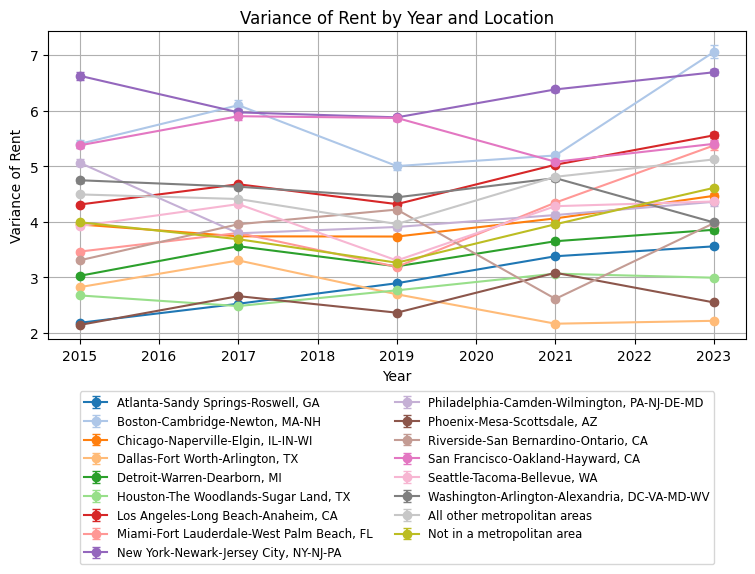

In [181]:
locs = loc_dat['LOCATION'].unique()
plt.figure(figsize = (9,4))
plt.rc('axes', prop_cycle = (plt.cycler('color', sns.color_palette("tab20"))))
for loc in locs:
    l_dat = loc_dat[loc_dat['LOCATION'] == loc]
    plt.errorbar(
        x = l_dat['YEAR'],
        y = l_dat['RENT', 'var'],
        yerr = l_dat['RENT', 'var_var'],
        label = loc,
        marker = 'o',
        capsize = 3,
    )
plt.legend(
    loc = 'upper center',
    bbox_to_anchor = (0.5, -0.15),
    ncol = 2,
    fontsize = 'small',
)
plt.grid()
plt.xlabel('Year')
plt.ylabel('Variance of Rent')
plt.title('Variance of Rent by Year and Location')
plt.show()

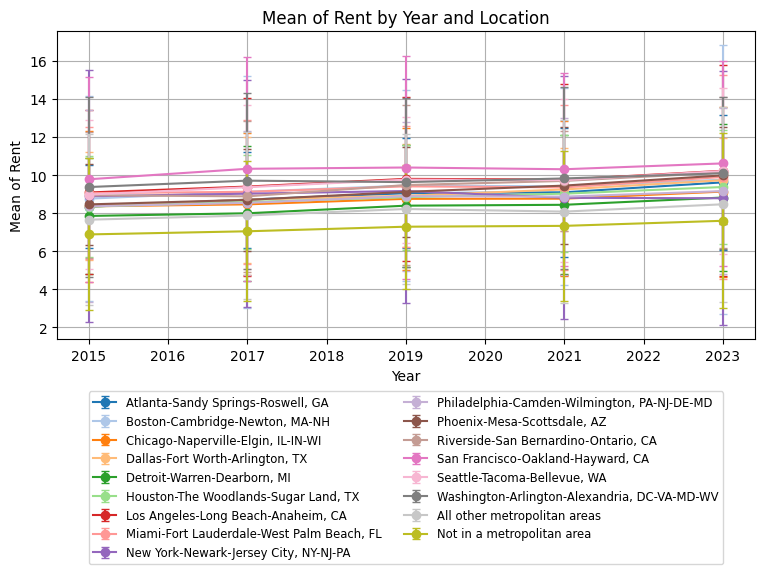

In [198]:
locs = loc_dat['LOCATION'].unique()
plt.figure(figsize = (9,4))
plt.rc('axes', prop_cycle = (plt.cycler('color', sns.color_palette("tab20"))))
for loc in locs:
    l_dat = loc_dat[loc_dat['LOCATION'] == loc]
    plt.errorbar(
        x = l_dat['YEAR'],
        y = l_dat['RENT', 'mean'],
        yerr = l_dat['RENT', 'var'],
        label = loc,
        marker = 'o',
        capsize = 3,
    )
plt.legend(
    loc = 'upper center',
    bbox_to_anchor = (0.5, -0.15),
    ncol = 2,
    fontsize = 'small',
)
plt.grid()
plt.xlabel('Year')
plt.ylabel('Mean of Rent')
plt.title('Mean of Rent by Year and Location')
plt.show()

In [183]:
a_list_prices = pd.read_csv('../../raw_data/apartment_list_market_prices.csv')
a_list_prices.drop(columns = ['p10', 'p90'], inplace = True)
a_list_prices['p75mp25'] = a_list_prices['p75'] - a_list_prices['p25']
a_list_prices

,market,year,month,p25,p50,p75,p75mp25
0,Atlanta,2020,1,1175.000000,1435.500000,1778.209677,603.209677
1,Atlanta,2020,2,1200.000000,1454.309524,1817.000000,617.000000
2,Atlanta,2020,3,1217.000000,1445.292857,1798.153650,581.153650
3,Atlanta,2020,4,1205.000000,1442.821429,1799.833333,594.833333
4,Atlanta,2020,5,1218.961538,1456.157895,1792.965517,574.003979
...,...,...,...,...,...,...,...
1795,Washington DC,2024,8,1900.000000,2286.666667,2763.000000,863.000000
1796,Washington DC,2024,9,1902.842105,2281.583333,2750.000000,847.157895
1797,Washington DC,2024,10,1915.000000,2275.000000,2766.000000,851.000000
1798,Washington DC,2024,11,1916.933333,2287.166667,2785.666667,868.733333


In [184]:
a_list_prices['date'] = pd.to_datetime(
    [f'{year}-{month}-01' for (year, month) in zip(a_list_prices['year'], a_list_prices['month'])]
)
a_list_prices.drop(columns = ['year', 'month', 'p25', 'p75'], inplace = True)
a_list_prices

,market,p50,p75mp25,date
0,Atlanta,1435.500000,603.209677,2020-01-01
1,Atlanta,1454.309524,617.000000,2020-02-01
2,Atlanta,1445.292857,581.153650,2020-03-01
3,Atlanta,1442.821429,594.833333,2020-04-01
4,Atlanta,1456.157895,574.003979,2020-05-01
...,...,...,...,...
1795,Washington DC,2286.666667,863.000000,2024-08-01
1796,Washington DC,2281.583333,847.157895,2024-09-01
1797,Washington DC,2275.000000,851.000000,2024-10-01
1798,Washington DC,2287.166667,868.733333,2024-11-01


/var/folders/0c/8jgwlmw579z5xqz61k4vsvcm0000gp/T/ipykernel_48524/1291850215.py:4: UserWarning: 
The palette list has fewer values (20) than needed (30) and will cycle, which may produce an uninterpretable plot.
  sns.lineplot(


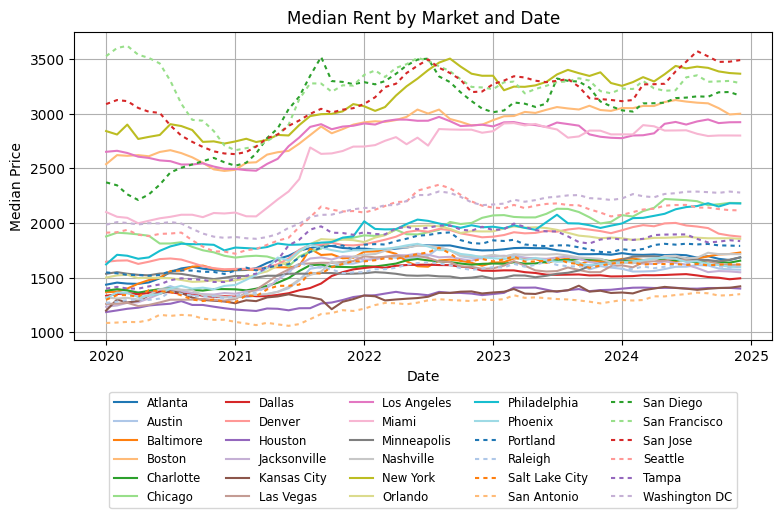

In [196]:
l_styles = [(2,2) if i >= 20 else '' for i in range(len(a_list_prices['market'].unique()))]
l_styles = dict(zip(a_list_prices['market'].unique(), l_styles))
plt.figure(figsize = (9,4))
sns.lineplot(
    data = a_list_prices,
    x = 'date',
    y = 'p50',
    hue = 'market',
    style = 'market',
    palette = sns.color_palette("tab20"),
    dashes = l_styles,
)
plt.legend(
    loc = 'upper center',
    bbox_to_anchor = (0.5, -0.15),
    ncol = 5,
    fontsize = 'small',
)
plt.xlabel('Date')
plt.ylabel('Median Price')
plt.grid()
plt.title('Median Rent by Market and Date')
plt.show()

/var/folders/0c/8jgwlmw579z5xqz61k4vsvcm0000gp/T/ipykernel_48524/993678940.py:2: UserWarning: 
The palette list has fewer values (20) than needed (30) and will cycle, which may produce an uninterpretable plot.
  sns.lineplot(


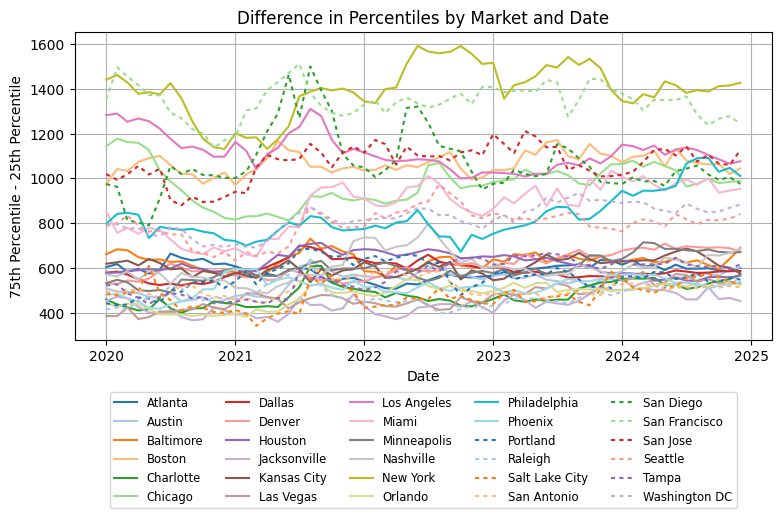

In [197]:
plt.figure(figsize = (9,4))
sns.lineplot(
    data = a_list_prices,
    x = 'date',
    y = 'p75mp25',
    hue = 'market',
    style = 'market',
    palette = sns.color_palette("tab20"),
    dashes = l_styles,
)
plt.legend(
    loc = 'upper center',
    bbox_to_anchor = (0.5, -0.15),
    ncol = 5,
    fontsize = 'small',
)
plt.xlabel('Date')
plt.ylabel('75th Percentile - 25th Percentile')
plt.grid()
plt.title('Difference in Percentiles by Market and Date')
plt.show()

In [187]:
reg_vars = pd.get_dummies(
    a_list_prices,
    columns=['market'],
    drop_first=True,
    dtype=int,
)
def months_since(date_now, date_origin):
    return (date_now.year - date_origin.year) * 12 + (date_now.month - date_origin.month)
date_origin = a_list_prices['date'].min()
reg_vars.insert(0, 'months_since', reg_vars['date'].apply(
    lambda x: months_since(x, date_origin)
))
var_reg = sm.OLS(
    endog = reg_vars['p75mp25'],
    exog = sm.add_constant(reg_vars.drop(columns=['p75mp25', 'date', 'p50'])),
).fit()
print(var_reg.summary())

                            OLS Regression Results                            
Dep. Variable:                p75mp25   R-squared:                       0.946
Model:                            OLS   Adj. R-squared:                  0.945
Method:                 Least Squares   F-statistic:                     1026.
Date:                Mon, 28 Apr 2025   Prob (F-statistic):               0.00
Time:                        17:26:45   Log-Likelihood:                -10042.
No. Observations:                1800   AIC:                         2.015e+04
Df Residuals:                    1769   BIC:                         2.032e+04
Df Model:                          30                                         
Covariance Type:            nonrobust                                         
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                   545.21

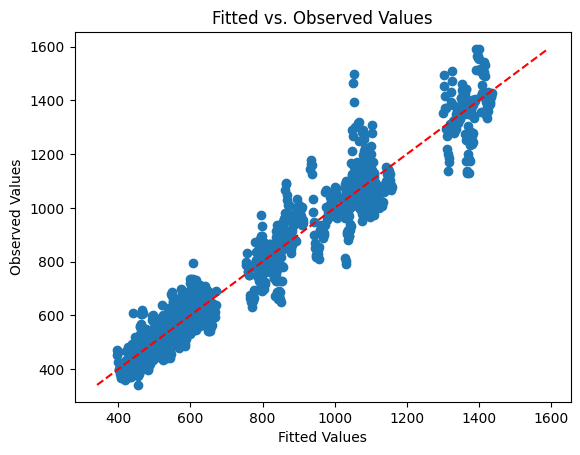

In [188]:
plt.plot(
    var_reg.fittedvalues,
    a_list_prices['p75mp25'],
    marker = 'o',
    linestyle = 'None',
)
plt.plot(
    [a_list_prices['p75mp25'].min(), a_list_prices['p75mp25'].max()],
    [a_list_prices['p75mp25'].min(), a_list_prices['p75mp25'].max()],
    color = 'red',
    linestyle = '--',
)
plt.xlabel('Fitted Values')
plt.ylabel('Observed Values')
plt.title('Fitted vs. Observed Values')
plt.show()